In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2024-05-12 16:42:04.986659: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-12 16:42:06.848282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 16:42:06.849257: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-12 16:42:07.218132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-12 16:42:07.220635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/CLEANED/'

In [5]:
data = C.Helper.load_separate_data(DATAPATH, 
                    types=('filt_img', 'filt_lb', 'filt_msk'), subsets=('train', 'test'))

In [6]:
filtered_images_train = data['filt_img_train']
filtered_images_test = data['filt_img_test']
filtered_labels_train = data['filt_lb_train']
filtered_labels_test = data['filt_lb_test']
filtered_masks_train = data['filt_msk_train']
filtered_masks_test = data['filt_msk_test']

In [15]:
# for i in range(len(filtered_images_train)):
#     for z in range(filtered_images_train[i].shape[0]):
#         plt.imshow(filtered_images_train[i][z,:,:])
#         plt.imshow(filtered_labels_train[i][z,:,:], cmap='gray', alpha=0.5)
#         plt.show()

In [16]:
# for i in range(len(filtered_images_train)):
#     print(filtered_images_train[i].shape, filtered_labels_train[i].shape, filtered_masks_train[i].shape)

In [17]:
# for i in range(len(filtered_images_test)):
#     print(filtered_images_test[i].shape, filtered_labels_test[i].shape, filtered_masks_test[i].shape)

In [9]:
normalized_images_train = C.Helper.normalize_data(filtered_images_train)
normalized_images_test = C.Helper.normalize_data(filtered_images_test)

In [10]:
normalized_masks_train = C.Helper.normalize_data(filtered_masks_train)
normalized_masks_test = C.Helper.normalize_data(filtered_masks_test)

In [11]:
last_key = np.concatenate(normalized_images_train[:round(len(normalized_images_train)*0.8)], axis=0)

In [12]:
last_key.shape[0]

354

In [13]:
X_train = np.concatenate(normalized_images_train, axis=0)
X_test = np.concatenate(normalized_images_test, axis=0)
y_train_array = np.concatenate(filtered_labels_train, axis=0)
y_test_array = np.concatenate(filtered_labels_test, axis=0)
m_train = np.concatenate(normalized_masks_train, axis=0)
m_test = np.concatenate(normalized_masks_test, axis=0)

In [15]:
len(X_train), len(X_test)

(449, 265)

In [18]:
new_slices = []
for i in range(len(y_train_array)):
    slices = np.where(y_train_array[i] != 0, True, False)
    new_slices.append(slices)
y_train = np.array(new_slices)

In [19]:
new_slices1 = []
for i in range(len(y_test_array)):
    slices = np.where(y_test_array[i] != 0, True, False)
    new_slices1.append(slices)
y_test = np.array(new_slices1)

In [20]:
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [21]:
train_masks=[]
for i in range(len(m_train)):
    binary = (m_train[i] > 0).astype(np.uint8)
    dilated = mh.dilate(binary.astype(np.bool_))
    for _ in range(9):
        dilated = mh.dilate(dilated)
    train_masks.append(dilated)

In [22]:
train_images=[]
for i in range(len(X_train)):
    train_image = X_train[i] * train_masks[i]
    train_images.append(train_image)
train_images_array = np.array(train_images)

In [23]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.show()

In [24]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.imshow(y_train[i], cmap='gray', alpha=0.5)
#     plt.show()

In [25]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# axes[0].imshow(X_train[11], vmin=0, vmax=1)
# axes[0].set_title('Original Image')
# axes[1].imshow(train_masks[11])
# axes[1].set_title('Mask')
# axes[2].imshow(train_images[11])
# axes[2].set_title('Processed Image')
# plt.show()

In [26]:
test_masks=[]
for i in range(len(m_test)):
    binary = (m_test[i] > 0).astype(np.uint8)
    dilated = mh.dilate(binary.astype(np.bool_))
    for _ in range(9):
        dilated = mh.dilate(dilated)
    test_masks.append(dilated)

In [27]:
test_images=[]
for i in range(len(X_test)):
    test_image = X_test[i] * test_masks[i]
    test_images.append(test_image)
test_images_array = np.array(test_images)

In [28]:
X_train_set = train_images_array[:last_key.shape[0]]
y_train_set = y_train[:last_key.shape[0]]
X_val = train_images_array[last_key.shape[0]:]
y_val = y_train[last_key.shape[0]:]

In [29]:
X_train_set.shape, y_train_set.shape

((354, 512, 512, 1), (354, 512, 512, 1))

In [30]:
X_val.shape, y_val.shape

((95, 512, 512, 1), (95, 512, 512, 1))

In [31]:
X_train_set.dtype, y_train_set.dtype

(dtype('float32'), dtype('float32'))

In [32]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-12 16:47:01.003704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-12 16:47:01.008050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-12 16:47:01.023818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-12 16:47:01.028379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-12 16:47:01.036546: I tensorflow/core

In [33]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2024-05-12 16:47:02.586400: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-12 16:47:02.610773: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/200


2024-05-12 16:47:03.996747: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-12 16:47:05.202685: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-12 16:47:06.880844: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-12 16:47:06.880867: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-12 16:47:06.881835: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-12 16:47:06.980431: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-12 16:47:08.436835: I tensorflow/stream_exec

11/11 [==============================] - 42s 2s/step - loss: 0.7816 - iou: 7.6312e-05 - iou_thresholded: 5.7722e-04 - val_loss: 0.0149 - val_iou: 2.1500e-04 - val_iou_thresholded: 0.0010
Epoch 2/200
11/11 [==============================] - 14s 1s/step - loss: 0.0561 - iou: 6.3940e-04 - iou_thresholded: 0.0042 - val_loss: 0.0054 - val_iou: 3.2334e-05 - val_iou_thresholded: 0.0010
Epoch 3/200
11/11 [==============================] - 10s 927ms/step - loss: 0.0036 - iou: 5.5144e-04 - iou_thresholded: 0.0015 - val_loss: 8.4262e-04 - val_iou: 0.0027 - val_iou_thresholded: 0.0010
Epoch 4/200
11/11 [==============================] - 10s 926ms/step - loss: 0.0016 - iou: 0.0048 - iou_thresholded: 0.0019 - val_loss: 6.5855e-04 - val_iou: 0.0070 - val_iou_thresholded: 0.0010
Epoch 5/200
11/11 [==============================] - 10s 926ms/step - loss: 0.0011 - iou: 0.0076 - iou_thresholded: 0.0018 - val_loss: 7.7420e-04 - val_iou: 0.0134 - val_iou_thresholded: 0.0010
Epoch 6/200
11/11 [=============

11/11 [==============================] - 10s 927ms/step - loss: 4.8962e-04 - iou: 0.2500 - iou_thresholded: 0.3590 - val_loss: 7.8869e-04 - val_iou: 0.1151 - val_iou_thresholded: 0.1322
Epoch 43/200
11/11 [==============================] - 10s 928ms/step - loss: 4.8227e-04 - iou: 0.2147 - iou_thresholded: 0.2980 - val_loss: 5.4671e-04 - val_iou: 0.1443 - val_iou_thresholded: 0.1926
Epoch 44/200
11/11 [==============================] - 10s 929ms/step - loss: 4.8802e-04 - iou: 0.2236 - iou_thresholded: 0.2987 - val_loss: 8.7639e-04 - val_iou: 0.1209 - val_iou_thresholded: 0.1507
Epoch 45/200
11/11 [==============================] - 10s 933ms/step - loss: 5.0834e-04 - iou: 0.2689 - iou_thresholded: 0.3898 - val_loss: 5.5375e-04 - val_iou: 0.1491 - val_iou_thresholded: 0.1943
Epoch 46/200
11/11 [==============================] - 10s 929ms/step - loss: 4.3761e-04 - iou: 0.2769 - iou_thresholded: 0.3930 - val_loss: 6.0083e-04 - val_iou: 0.1648 - val_iou_thresholded: 0.1884
Epoch 47/200
11/11

11/11 [==============================] - 10s 929ms/step - loss: 2.2197e-04 - iou: 0.5056 - iou_thresholded: 0.6107 - val_loss: 6.1867e-04 - val_iou: 0.3120 - val_iou_thresholded: 0.3923
Epoch 84/200
11/11 [==============================] - 10s 925ms/step - loss: 2.2043e-04 - iou: 0.4901 - iou_thresholded: 0.5964 - val_loss: 5.8008e-04 - val_iou: 0.3391 - val_iou_thresholded: 0.3954
Epoch 85/200
11/11 [==============================] - 11s 1s/step - loss: 2.5247e-04 - iou: 0.4847 - iou_thresholded: 0.5938 - val_loss: 5.8694e-04 - val_iou: 0.3574 - val_iou_thresholded: 0.4081
Epoch 86/200
11/11 [==============================] - 10s 1s/step - loss: 2.3372e-04 - iou: 0.5136 - iou_thresholded: 0.6283 - val_loss: 5.4536e-04 - val_iou: 0.3691 - val_iou_thresholded: 0.4365
Epoch 87/200
11/11 [==============================] - 10s 928ms/step - loss: 2.2873e-04 - iou: 0.4793 - iou_thresholded: 0.5883 - val_loss: 5.7873e-04 - val_iou: 0.3383 - val_iou_thresholded: 0.4257
Epoch 88/200
11/11 [====

11/11 [==============================] - 10s 926ms/step - loss: 1.6820e-04 - iou: 0.5970 - iou_thresholded: 0.6953 - val_loss: 5.7052e-04 - val_iou: 0.4374 - val_iou_thresholded: 0.4985
Epoch 125/200
11/11 [==============================] - 10s 931ms/step - loss: 1.6784e-04 - iou: 0.5934 - iou_thresholded: 0.6710 - val_loss: 6.7194e-04 - val_iou: 0.4287 - val_iou_thresholded: 0.4814
Epoch 126/200
11/11 [==============================] - 10s 933ms/step - loss: 1.6149e-04 - iou: 0.5801 - iou_thresholded: 0.6660 - val_loss: 6.7937e-04 - val_iou: 0.4201 - val_iou_thresholded: 0.4823
Epoch 127/200
11/11 [==============================] - 10s 928ms/step - loss: 1.5333e-04 - iou: 0.6018 - iou_thresholded: 0.7020 - val_loss: 7.5783e-04 - val_iou: 0.4200 - val_iou_thresholded: 0.4724
Epoch 128/200
11/11 [==============================] - 10s 925ms/step - loss: 1.5224e-04 - iou: 0.5826 - iou_thresholded: 0.6620 - val_loss: 7.1942e-04 - val_iou: 0.4390 - val_iou_thresholded: 0.4921
Epoch 129/200


11/11 [==============================] - 10s 930ms/step - loss: 1.4226e-04 - iou: 0.5860 - iou_thresholded: 0.6669 - val_loss: 6.9894e-04 - val_iou: 0.4253 - val_iou_thresholded: 0.4874
Epoch 166/200
11/11 [==============================] - 10s 925ms/step - loss: 1.2569e-04 - iou: 0.6845 - iou_thresholded: 0.7776 - val_loss: 7.6136e-04 - val_iou: 0.4449 - val_iou_thresholded: 0.4984
Epoch 167/200
11/11 [==============================] - 10s 928ms/step - loss: 1.2309e-04 - iou: 0.6851 - iou_thresholded: 0.7711 - val_loss: 8.5932e-04 - val_iou: 0.4316 - val_iou_thresholded: 0.4847
Epoch 168/200
11/11 [==============================] - 10s 926ms/step - loss: 1.2504e-04 - iou: 0.6456 - iou_thresholded: 0.7225 - val_loss: 7.6768e-04 - val_iou: 0.4286 - val_iou_thresholded: 0.4735
Epoch 169/200
11/11 [==============================] - 11s 1s/step - loss: 1.2252e-04 - iou: 0.6754 - iou_thresholded: 0.7641 - val_loss: 7.5170e-04 - val_iou: 0.4399 - val_iou_thresholded: 0.4896
Epoch 170/200
11/

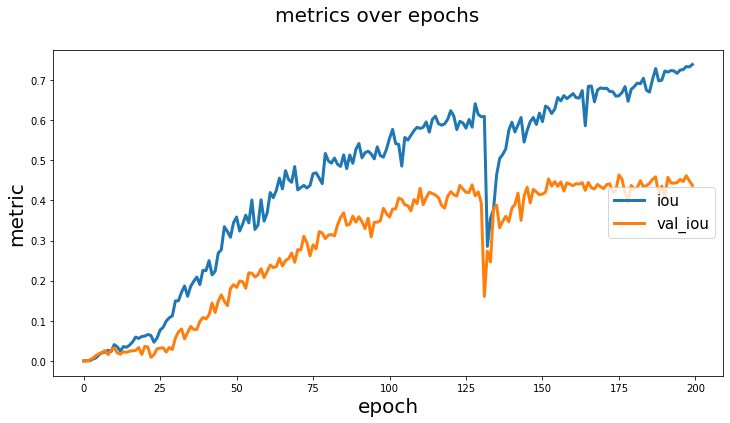

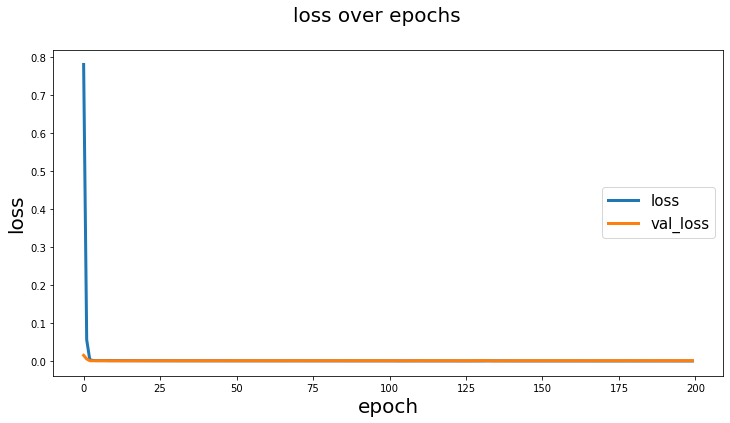

In [34]:
C.Helper.visualize_graph(history)

In [35]:
y_pred = C.Helper.prediction(test_images_array, model)

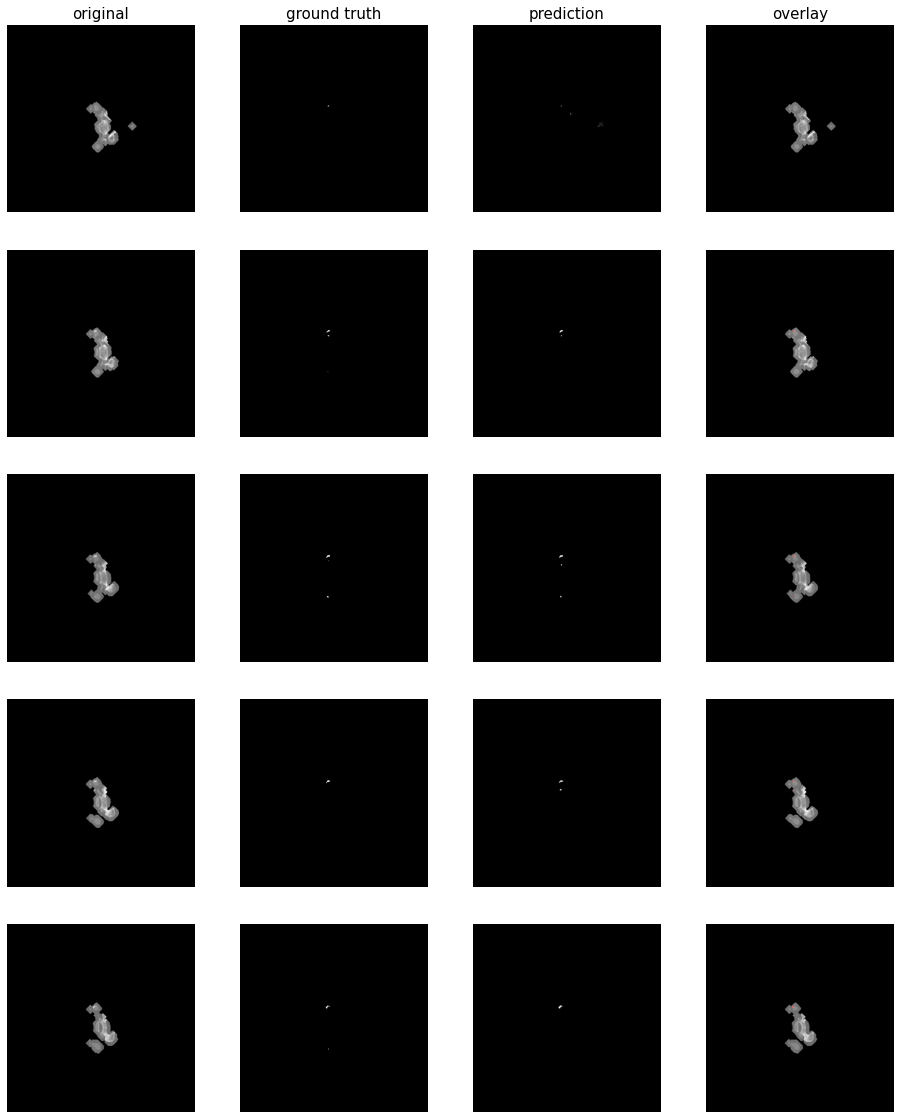

In [36]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [37]:
C.Helper.evaluate(test_images_array, y_test, model)

9/9 [==============================] - 2s 201ms/step - loss: 0.0011 - iou: 0.4836 - iou_thresholded: 0.5256
